# Lecture 10. Metrics and Model Selection for Regression and Classification

# Regression

In [1]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [ ]:
housing = pd.read_csv("https://raw.githubusercontent.com/ageron/handson-ml2/master/datasets/housing/housing.csv")
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [ ]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [ ]:
housing.dropna(subset = ['total_bedrooms'], inplace=True)

In [ ]:
y = housing['median_house_value']
housing.drop(columns=['median_house_value'], inplace=True)

In [ ]:
housing['ocean_proximity'].value_counts()

<1H OCEAN     9034
INLAND        6496
NEAR OCEAN    2628
NEAR BAY      2270
ISLAND           5
Name: ocean_proximity, dtype: int64

Create a random feature to see how to detect not important features

In [ ]:
housing['random'] = (np.random.rand(len(housing))>0.5).astype(int)

### Split data into Train and Test

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(housing, y, test_size=0.2, random_state=42)

Create transformer for the nominal data

In [ ]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

In [ ]:
transform = ColumnTransformer([('OneHot', OneHotEncoder(drop='first'), ['ocean_proximity'])], remainder='passthrough')
transform.fit(X_train)

ColumnTransformer(remainder='passthrough',
                  transformers=[('OneHot', OneHotEncoder(drop='first'),
                                 ['ocean_proximity'])])

After transformer our data looks as follows

In [ ]:
X_train_hot = pd.DataFrame(transform.transform(X_train), columns=transform.get_feature_names_out())
X_train_hot.head()

,OneHot__ocean_proximity_INLAND,OneHot__ocean_proximity_ISLAND,OneHot__ocean_proximity_NEAR BAY,OneHot__ocean_proximity_NEAR OCEAN,remainder__longitude,remainder__latitude,remainder__housing_median_age,remainder__total_rooms,remainder__total_bedrooms,remainder__population,remainder__households,remainder__median_income,remainder__random
0,0.0,0.0,0.0,0.0,-121.80,37.32,14.0,4412.0,924.0,2698.0,891.0,4.7027,0.0
1,1.0,0.0,0.0,0.0,-119.63,36.64,33.0,1036.0,181.0,620.0,174.0,3.4107,0.0
2,1.0,0.0,0.0,0.0,-118.06,34.12,25.0,3891.0,848.0,1848.0,759.0,3.6639,0.0
3,0.0,0.0,0.0,0.0,-118.31,34.07,28.0,2362.0,949.0,2759.0,894.0,2.2364,0.0
4,0.0,0.0,0.0,1.0,-117.27,33.04,27.0,1839.0,392.0,1302.0,404.0,3.5500,1.0


## Choosing Data by Correlation, Mutual Information, and by Model

$$
\operatorname{Cor}(X;Y) = \frac{(X-\bar{X})^T (Y-\bar{Y})}{\sqrt{\operatorname{Var}[X]}\sqrt{\operatorname{Var}[Y]}}
$$

Add target variable to the data to see the correlation

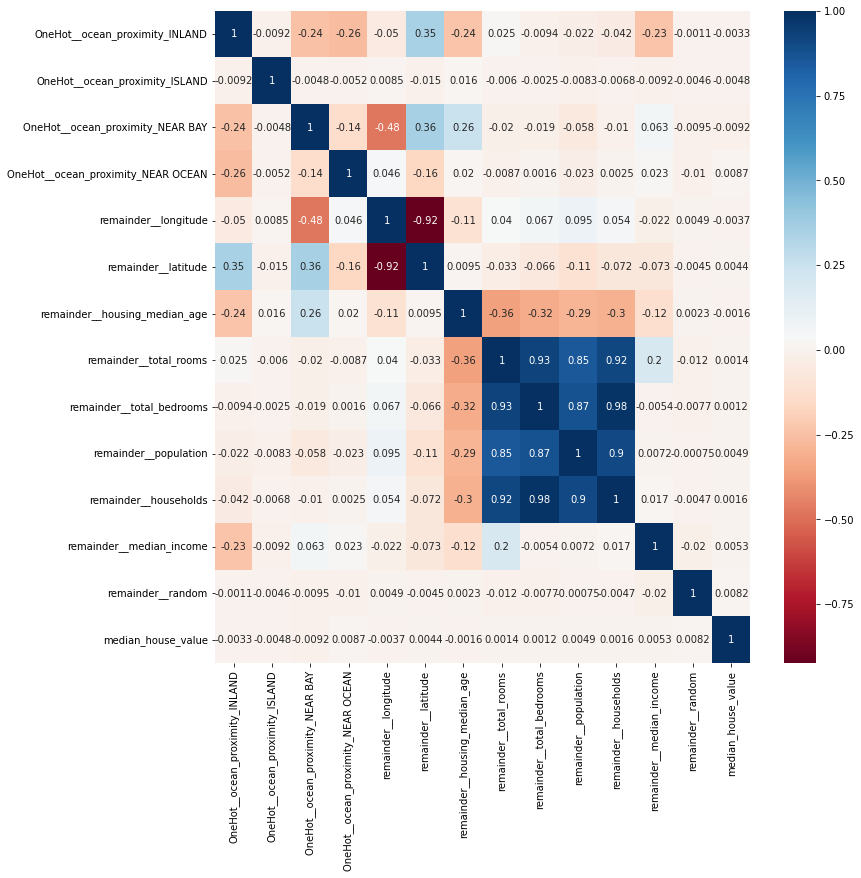

In [ ]:
cor = pd.concat([X_train_hot, y_train], axis=1).corr()
fig, ax = plt.subplots(figsize=(12,12))    
sns.heatmap(cor, cmap="RdBu", annot=True)

## Validation Set

In [ ]:
X_train_hot_val, X_hot_val, y_train_val, y_val = train_test_split(X_train_hot, y_train, test_size=0.2, random_state=42)

In [ ]:
from sklearn.linear_model import SGDRegressor, Lasso, Ridge, ARDRegression, ElasticNet, HuberRegressor
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.feature_selection import SelectKBest, mutual_info_regression, r_regression, f_regression 
from sklearn.pipeline import Pipeline, make_pipeline

## Trying Different Models
$$
MSE = \frac{1}{N}\sum_{i=1}^{N}\left(a(x^{(i)})-y^{(i)}\right)^2
$$
$$
MAE = \frac{1}{N}\sum_{i=1}^{N}\left|a(x^{(i)})-y^{(i)}\right|
$$
$$
Huber = \frac{1}{N}\sum_{i=1}^{N} \phi_{\varepsilon}\left(a(x^{(i)})-y^{(i)}\right), 
$$
where
$$
\phi_{\varepsilon}(z) =\begin{cases}\dfrac{1}{2} z^2, & |z|<\varepsilon,\\
\varepsilon\left( |z|-\dfrac{1}{2}\varepsilon\right), & |z|\geq \varepsilon. \end{cases}
$$
$l_2$ regularization
$$
\|w\|_2^2 = \sum_{k=1}^{D} w_k^2
$$
$l_1$ regularization
$$
\|w\|_1 = \sum_{k=1}^{D} |w_k|
$$
Elastic
$$
a\|w\|_1 + \dfrac{1}{2}b\|w\|_2^2
$$

First model is using ridge regression after selecting 9 features with larger correlation

In [ ]:
pipe1 = Pipeline([('select', SelectKBest(r_regression, k=9)), ('sc', StandardScaler()), ('reg', Ridge())])

We test it on the validation set

In [ ]:
pipe1.fit(X_train_hot_val, y_train_val)
pipe1.score(X_hot_val, y_val)

0.5717520113322241

In [ ]:
pipe1[:-1].get_feature_names_out()

array(['OneHot__ocean_proximity_ISLAND',
       'OneHot__ocean_proximity_NEAR BAY',
       'OneHot__ocean_proximity_NEAR OCEAN',
       'remainder__housing_median_age', 'remainder__total_rooms',
       'remainder__total_bedrooms', 'remainder__households',
       'remainder__median_income', 'remainder__random'], dtype=object)

Second model is using ridge regression with all fetures

In [ ]:
pipe2 = Pipeline([('sc', StandardScaler()), ('reg', Ridge())])
pipe2.fit(X_train_hot_val, y_train_val)
pipe2.score(X_hot_val, y_val)

0.6570990655108501

Coefficient of Determination
$$
R^2 = 1-\frac{\sum\limits_{i=1}^{N}\left(a(x^{(i)})-y^{(i)}\right)^2}{\sum\limits_{i=1}^{N}\left(y^{(i)}-\bar{y}\right)^2}
$$

**Why do we need the scaler?**

## Cross-Validation

In [ ]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(pipe1, X_train_hot, y_train, cv=10)
print(scores, scores.mean())

[0.59754886 0.57903001 0.55392081 0.50736668 0.57545052 0.59679177
 0.55993243 0.5518245  0.56911289 0.55092614] 0.5641904606442619


Correlation analyzis and cross-validation

In [ ]:
corr_select = []
for r in range(1,X_train_hot.shape[1]+1):
  pipe1 = Pipeline([('sc', StandardScaler()), ('reg', Ridge())])
  corr_select.append(cross_val_score(pipe1, SelectKBest(r_regression, k=r).fit_transform(X_train_hot, y_train), y_train, cv=10).mean())

Text(0, 0.5, 'Score $R^2$')

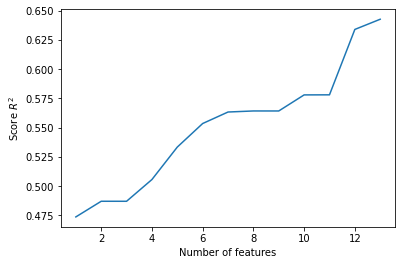

In [ ]:
plt.plot(list(range(1, X_train_hot.shape[1]+1)), corr_select)
plt.xlabel('Number of features')
plt.ylabel('Score $R^2$')

## Mutual Information
$$
I(X;Y) = \sum_{y\in Y}\sum_{x\in X} p(x,y) \log\frac{p(x,y)}{p(x)p(y)}
$$

In [ ]:
MI_select = []
for r in range(1, X_train_hot.shape[1]+1):
  pipe2 = Pipeline([('sc', StandardScaler()), ('reg', Ridge())])
  MI_select.append(cross_val_score(pipe2, SelectKBest(mutual_info_regression, k=r).fit_transform(X_train_hot, y_train), y_train, cv=10).mean())

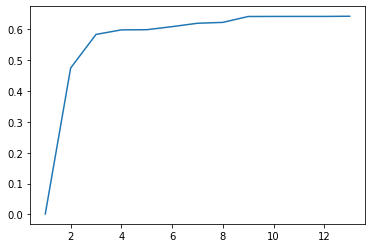

In [ ]:
plt.plot(list(range(1, X_train_hot.shape[1]+1)), MI_select)

We can use the better number of the features selected by MI

In [ ]:
selector_MI = SelectKBest(mutual_info_regression, k=9)
selector_MI.fit_transform(X_train_hot, y_train)
selector_MI.get_feature_names_out()

array(['OneHot__ocean_proximity_INLAND', 'remainder__longitude',
       'remainder__latitude', 'remainder__housing_median_age',
       'remainder__total_rooms', 'remainder__total_bedrooms',
       'remainder__population', 'remainder__households',
       'remainder__median_income'], dtype=object)

## Recursive Feature Elimination 

In [ ]:
from sklearn.feature_selection import RFE

In [ ]:
Rec_select = []
for r in range(1, X_train_hot.shape[1]+1):
  estimator = Lasso()
  scaler = StandardScaler()
  selector = RFE(estimator, n_features_to_select=r)
  selector.fit(scaler.fit_transform(X_train_hot), y_train)
  Rec_select.append(cross_val_score(estimator, scaler.fit_transform(X_train_hot[selector.get_feature_names_out(X_train_hot.columns.values)]), y_train, cv=10).mean())

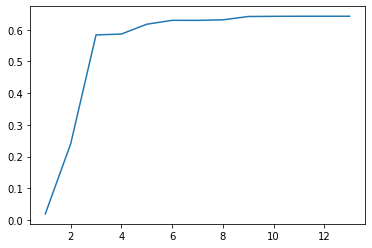

In [ ]:
plt.plot(list(range(1, X_train_hot.shape[1]+1)), Rec_select)

In [ ]:
estimator = Ridge()
scaler = StandardScaler()
selector_Rec = RFE(estimator, n_features_to_select=10)
#X_train_hot_scaled = pd.DataFrame(scaler.fit_transform(X_train_hot), columns=X_train_hot.columns.values)
selector_Rec.fit(scaler.fit_transform(X_train_hot), y_train)
selector_Rec.get_feature_names_out(X_train_hot.columns.values)

array(['OneHot__ocean_proximity_INLAND', 'OneHot__ocean_proximity_ISLAND',
       'remainder__longitude', 'remainder__latitude',
       'remainder__housing_median_age', 'remainder__total_rooms',
       'remainder__total_bedrooms', 'remainder__population',
       'remainder__households', 'remainder__median_income'], dtype=object)

## Creating New Features

In [ ]:
#sns.pairplot(pd.concat([housing_hot, y_train], axis=1))

## Model Selection Via Grid Search

In [ ]:
pipe3 = Pipeline([('select', SelectKBest()),('sc', StandardScaler()), ('reg', Lasso())]) 

In [ ]:
pipe3.get_params()

{'memory': None,
 'reg': Lasso(),
 'reg__alpha': 1.0,
 'reg__copy_X': True,
 'reg__fit_intercept': True,
 'reg__max_iter': 1000,
 'reg__normalize': 'deprecated',
 'reg__positive': False,
 'reg__precompute': False,
 'reg__random_state': None,
 'reg__selection': 'cyclic',
 'reg__tol': 0.0001,
 'reg__warm_start': False,
 'sc': StandardScaler(),
 'sc__copy': True,
 'sc__with_mean': True,
 'sc__with_std': True,
 'select': SelectKBest(),
 'select__k': 10,
 'select__score_func': <function sklearn.feature_selection._univariate_selection.f_classif>,
 'steps': [('select', SelectKBest()),
  ('sc', StandardScaler()),
  ('reg', Lasso())],
 'verbose': False}

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
param_grid = {'select__score_func': [mutual_info_regression, f_regression],
              'select__k': [8, 9],
              'reg__alpha': [0.1, 0.5],
              } #'reg__penalty': ['l2', 'l1']} for SGDRegressor(max_iter=700,alpha=0.2)

In [ ]:
grid_search = GridSearchCV(pipe3, param_grid, cv=5)

In [ ]:
grid_search.fit(X_train_hot, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('select', SelectKBest()),
                                       ('sc', StandardScaler()),
                                       ('reg', Lasso())]),
             param_grid={'reg__alpha': [0.1, 0.5], 'select__k': [8, 9],
                         'select__score_func': [<function mutual_info_regression at 0x7f1d47bd0170>,
                                                <function f_regression at 0x7f1d47d7f3b0>]})

In [ ]:
grid_search.best_estimator_

Pipeline(steps=[('select',
                 SelectKBest(k=9,
                             score_func=<function mutual_info_regression at 0x7f1d47bd0170>)),
                ('sc', StandardScaler()), ('reg', Lasso(alpha=0.1))])

# Final training and testing

In [ ]:
best_model = SGDRegressor(alpha=0.001, penalty='elasticnet')
best_features = selector_MI.get_feature_names_out().tolist()

In [ ]:
pipe = Pipeline([('scaler', StandardScaler()), ('model', best_model)])

In [ ]:
pipe.fit(X_train_hot[best_features],y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('model', SGDRegressor(alpha=0.001, penalty='elasticnet'))])

In [ ]:
X_test_hot = pd.DataFrame(transform.fit_transform(X_test), columns=transform.get_feature_names_out())

Predict for all test records

In [ ]:
y_predict = pipe.predict(X_test_hot[best_features])

In [ ]:
y_predict[0]

199102.91761176274

Choose one record from the DataFrame (use doble brackets)

In [ ]:
X_test.iloc[[0]]

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,random
14416,-117.24,32.79,20.0,961.0,278.0,525.0,254.0,3.1838,NEAR OCEAN,1


Transform it if needed

In [ ]:
X_transformed = pd.DataFrame(transform.transform(X_test.iloc[[0]]), columns=transform.get_feature_names_out())
X_transformed

,OneHot__ocean_proximity_INLAND,OneHot__ocean_proximity_ISLAND,OneHot__ocean_proximity_NEAR BAY,OneHot__ocean_proximity_NEAR OCEAN,remainder__longitude,remainder__latitude,remainder__housing_median_age,remainder__total_rooms,remainder__total_bedrooms,remainder__population,remainder__households,remainder__median_income,remainder__random
0,0.0,0.0,0.0,1.0,-117.24,32.79,20.0,961.0,278.0,525.0,254.0,3.1838,1.0


Make a prediction for this record

In [ ]:
pipe.predict(X_transformed[best_features]), y_test.iloc[0]

(array([199102.91761176]), 245800.0)

You could do it by using weights $w_i$

$$
a(x) = w_0 + w_1 x_1+\ldots + w_d x_d = w^T \tilde{x},
$$
where
$$
\tilde{x} = (1,\ x_1,\ x_2, \ldots,\ x_d)^T
$$

In [ ]:
pipe[-1].coef_

array([-17565.22278274, -52380.41118718, -54227.18516983,  14222.44143994,
       -13262.6283369 ,  40629.21151607, -41341.67954257,  16358.62385154,
        74199.92064341])

In [ ]:
pipe[-1].intercept_

array([205151.36881982])

In [ ]:
pipe[0].transform(X_transformed[best_features]).dot(pipe[-1].coef_) + pipe[-1].intercept_

array([199102.91761176])

#Summary
* ## Split Train/Validation/Test
* ## or Train/Test and use cross-validation
* ## Feature selection (by correlation/MI or by model)
* ## and probably new features
* ## Regression model selection + its parameters by grid-search
* ## Calculate chosen metric (MSE, MAE, or $R^2$) on the Test set 


# Regression for Classification

We can use 
$$
\operatorname{sign}(a(x)) = \operatorname{sign}\left(w^T x\right)  
$$
to classify our data labeled $y=1$ or $y=-1$.

The line (hyperplane)
$$
w^T x =0
$$
is called a *decision boundary.*

**How can we interprete $w^T x$?**

$$
M = y w^T x
$$
$M>0$ for correct classification and $M<0$ otherwise.

In [3]:
Data = pd.read_csv('https://raw.githubusercontent.com/anton-selitskiy/The-Art-of-ML/main/scoring.csv')
#source: https://github.com/nadiinchi/voronovo_seminar_materials/tree/master/base_track/seminars

In [4]:
Data.head()

,account,duration,credit_history,amount,savings,employment,guarantors,residence,age,credits_number,job,maintenance_people,telephone,foreign,real_estate,life_insurance,car,housing_rent,sex,purpose,target
0,1,0.18,2,0.13110,2,2,1,4,0.34,1,2,1,0,1,0,0,1,0,1,business,1
1,-1,0.18,0,0.15520,1,3,1,1,0.31,1,2,1,1,1,0,1,0,0,1,business,1
2,-1,0.12,2,0.04510,1,3,1,4,0.21,1,2,1,0,1,0,1,0,1,1,retraining,0
3,-1,0.30,0,0.40360,0,1,1,3,0.25,3,2,1,0,1,0,0,1,0,1,business,1
4,0,0.36,2,0.09095,1,2,1,4,0.37,1,2,1,1,1,0,0,0,0,1,education,0


In [ ]:
Data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   account             600 non-null    int64  
 1   duration            600 non-null    float64
 2   credit_history      600 non-null    int64  
 3   amount              600 non-null    float64
 4   savings             600 non-null    int64  
 5   employment          600 non-null    int64  
 6   guarantors          600 non-null    int64  
 7   residence           600 non-null    int64  
 8   age                 600 non-null    float64
 9   credits_number      600 non-null    int64  
 10  job                 600 non-null    int64  
 11  maintenance_people  600 non-null    int64  
 12  telephone           600 non-null    int64  
 13  foreign             600 non-null    int64  
 14  real_estate         600 non-null    int64  
 15  life_insurance      600 non-null    int64  
 16  car     

In [ ]:
Data['target'].value_counts()

1    300
0    300
Name: target, dtype: int64

Because classes are balanced, we can use accuracy as the mertic.

In [ ]:
Data['target'] = Data['target'].map({0: -1, 1: 1})
Data.head()

,account,duration,credit_history,amount,savings,employment,guarantors,residence,age,credits_number,job,maintenance_people,telephone,foreign,real_estate,life_insurance,car,housing_rent,sex,purpose,target
0,1,0.18,2,0.13110,2,2,1,4,0.34,1,2,1,0,1,0,0,1,0,1,business,1
1,-1,0.18,0,0.15520,1,3,1,1,0.31,1,2,1,1,1,0,1,0,0,1,business,1
2,-1,0.12,2,0.04510,1,3,1,4,0.21,1,2,1,0,1,0,1,0,1,1,retraining,-1
3,-1,0.30,0,0.40360,0,1,1,3,0.25,3,2,1,0,1,0,0,1,0,1,business,1
4,0,0.36,2,0.09095,1,2,1,4,0.37,1,2,1,1,1,0,0,0,0,1,education,-1


In [ ]:
X = Data[Data.columns[:-2]] #Don't take into account the thext column
y = Data['target'] 

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_val, X_val, y_train_val, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline

In [ ]:
pipe = Pipeline([('scaler', StandardScaler()), ('model', LinearRegression())])
pipe.fit(X_train_val, y_train_val)

Pipeline(steps=[('scaler', StandardScaler()), ('model', LinearRegression())])

In [ ]:
y_predict = pipe.predict(X_train_val)

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
y_predict_val = pipe.predict(X_val)
accuracy_score(y_val, np.sign(y_predict_val))

0.6458333333333334

**Task** Create table with features and importance

In [ ]:
pd.DataFrame({'feature': X.columns, 'weight': pipe[-1].coef_}).sort_values('weight')

,feature,weight
1,duration,-0.191204
13,foreign,-0.106976
9,credits_number,-0.094359
17,housing_rent,-0.084107
11,maintenance_people,-0.047476
6,guarantors,-0.042150
15,life_insurance,-0.022934
10,job,-0.011041
7,residence,0.001071
4,savings,0.002312


Calculate precision and recall for the threshold $th = 0$

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score

In [ ]:
CM = confusion_matrix(y_train_val, np.sign(y_predict))
CM

array([[131,  59],
       [ 60, 134]])

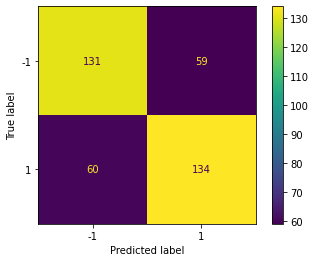

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_train_val, np.sign(y_predict))

In [ ]:
precision_score(y_train_val, np.sign(y_predict))

0.694300518134715

In [ ]:
134/(134+59)

0.694300518134715

# Precision - Recall Curve
## Comment: we could do model selection using only accuracy or f1 measure, but my goal is to make you familiar with area under the curve (AUC) measure of quality.

In [ ]:
pd.DataFrame({'prediction': y_predict[:6], 'target': y_train_val[:6].to_numpy()}).sort_values('prediction', ascending=False)

,prediction,target
4,0.308977,1
3,0.035421,1
0,0.022256,-1
5,-0.027611,-1
1,-0.177733,-1
2,-0.247301,1


**Right a function to calculate Precision curve**

In [ ]:
def prec(y, y_p):
  alpha = np.linspace(y_p.min(), y_p.max(), num=50)[1:-1]
  a = []
  for th in alpha:
    a.append(precision_score(y, np.sign(y_p-th)))
  return alpha, a

In [ ]:
def rec(y, y_p):
  alpha = np.linspace(y_p.min(), y_p.max(), num=50)[1:-1]
  a = []
  for th in alpha:
    a.append(recall_score(y, np.sign(y_p-th)))
  return alpha, a

In [ ]:
def f1(y, y_p):
  alpha = np.linspace(y_p.min(), y_p.max(), num=50)[1:-1]
  a = []
  for th in alpha:
    a.append(f1_score(y, np.sign(y_p-th)))
  return alpha, a

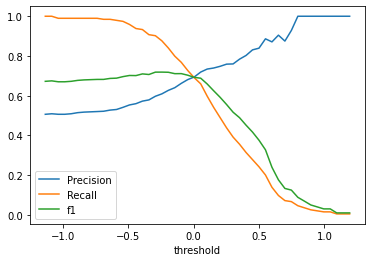

In [ ]:
alpha, p = prec(y_train_val.to_numpy(), y_predict)
alpha, r = rec(y_train_val.to_numpy(), y_predict)
alpha, f1 = f1(y_train_val.to_numpy(), y_predict)
plt.plot(alpha, p, label='Precision')
plt.plot(alpha, r, label='Recall')
plt.plot(alpha, f1, label='f1')
plt.xlabel('threshold')
plt.legend()

If we want to maximize both precision and recall, we can use $F$-measure
$$
F_{\beta} = (1+\beta)^2 \frac{precision\times recall}{\beta^2 precision+recall}
$$
\
$$
F_1 =  \frac{2}{\dfrac{1}{precision}+\dfrac{1}{recall}} = 2\frac{precision\times recall}{precision+recall}
$$
**Find maximum f1**

In [ ]:
np.argmax(f1)

18

In [ ]:
alpha[np.argmax(f1)]

-0.24213230448505707

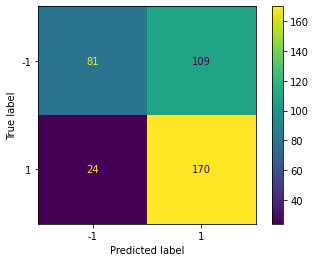

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_train_val, np.sign(y_predict-alpha[np.argmax(f1)]))

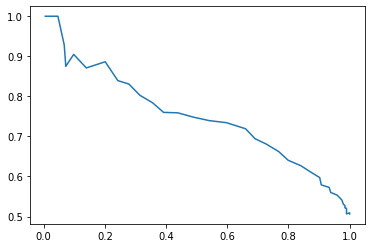

In [ ]:
plt.plot(r,p)

In [ ]:
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay

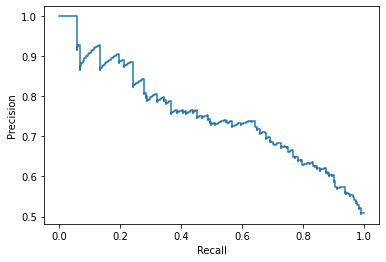

In [ ]:
precision, recall, _ = precision_recall_curve(y_train_val, y_predict)
disp = PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot()

# ROC curve


$$
TPR = \frac{TP}{TP+FN}
$$

$$
FPR = \frac{FP}{FP+TN}
$$

In [ ]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_val, y_predict)

In [ ]:
from sklearn.metrics import RocCurveDisplay

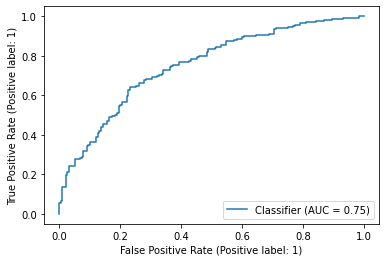

In [ ]:
RocCurveDisplay.from_predictions(y_train_val, y_predict)

Let's try another model: Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
pipe1 = Pipeline([('scaler', StandardScaler()), ('model', LogisticRegression())])

In [ ]:
pipe1.fit(X_train_val, y_train_val)

Pipeline(steps=[('scaler', StandardScaler()), ('model', LogisticRegression())])

In [ ]:
y_predict1 = pipe1.predict(X_train_val)
y_predict1_proba = pipe1.predict_proba(X_train_val)

In [ ]:
y_val_predict1 = pipe1.predict(X_val)
accuracy_score(y_val, y_val_predict1)

0.6458333333333334

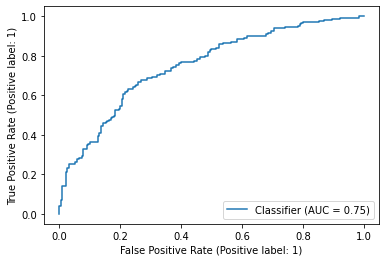

In [ ]:
RocCurveDisplay.from_predictions(y_train_val, y_predict1_proba[:,-1])

Let's try SVM classifier

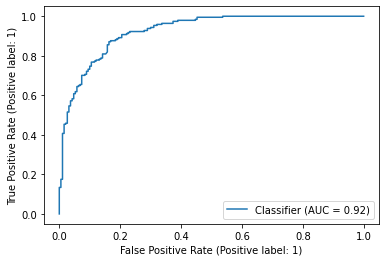

In [ ]:
from sklearn.svm import SVC
pipe2 = Pipeline([('scaler', StandardScaler()), ('model', SVC(probability=True))])
pipe2.fit(X_train_val,y_train_val)
y_predict2_proba = pipe2.predict_proba(X_train_val)
RocCurveDisplay.from_predictions(y_train_val, y_predict2_proba[:,-1])

In [ ]:
y_val_predict2 = pipe2.predict(X_val)
accuracy_score(y_val, y_val_predict2)

0.6458333333333334

We should prefer the last model. Let's see there performance on the Test:

In [ ]:
y_test_predict1 = pipe1.predict(X_test)
accuracy_score(y_test, y_test_predict1)

0.6416666666666667

In [ ]:
y_test_predict2 = pipe2.predict(X_test)
accuracy_score(y_test, y_test_predict2)

0.7

# Loss Function for Classification
$$
L = \frac{1}{N} \sum_{i=1}^{N} [y^{(i)} \ne \operatorname{sign}(w^T x) ] = \frac{1}{N} \sum_{i=1}^{N} [y^{(i)}w^T x <0]
$$

Text(0, 0.5, 'Loss')

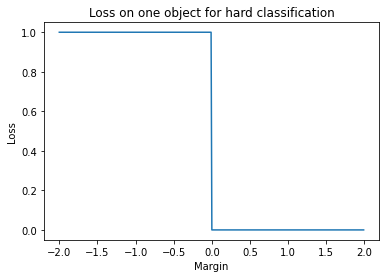

In [ ]:
x = np.arange(-2,2,0.01).tolist()
Los = list(map(lambda x: 0 if x>0 else 1, x))
plt.plot(x,Los)
plt.title('Loss on one object for hard classification')
plt.xlabel('Margin')
plt.ylabel('Loss')

$$
L = \frac{1}{N} \sum_{i=1}^{N} [y^{(i)}w^T x <0] \leq  \frac{1}{N} \sum_{i=1}^{N} \log \left(1 + e^{-y^{(i)}w^T x}\right)
$$

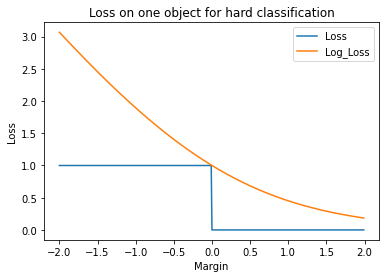

In [ ]:
Log_Los = list(map(lambda x: np.log2(1+np.exp(-x)), x))
plt.plot(x,Los, label='Loss')
plt.plot(x,Log_Los, label='Log_Loss')
plt.title('Loss on one object for hard classification')
plt.xlabel('Margin')
plt.ylabel('Loss')
plt.legend()

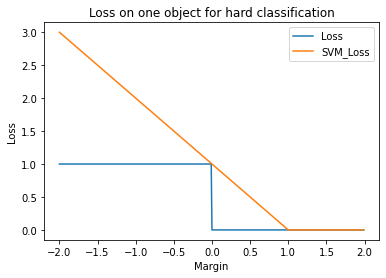

In [ ]:
SVM_Los = list(map(lambda x: np.max([0, 1-x]), x))
plt.plot(x,Los, label='Loss')
plt.plot(x,SVM_Los, label='SVM_Loss')
plt.title('Loss on one object for hard classification')
plt.xlabel('Margin')
plt.ylabel('Loss')
plt.legend()

$$
L = \frac{1}{N} \sum_{i=1}^{N} [y^{(i)}w^T x <0] \leq  \frac{1}{N} \sum_{i=1}^{N} \max \left(0,\ 1 -y^{(i)}w^T x\right)
$$

# Logistic Regression as Probabilistic Model
Consider the function $\sigma\colon \mathbb{R}\to [0;\ 1]$
$$
\sigma(x) = \frac{e^x}{1+e^x} = \frac{1}{1+e^{-x}}
$$
If we take $\sigma$ of the margin as probability, then maximum likelihood estimation takes form
$$
\prod_{i=1}^{N} \frac{1}{1+e^{-y^{(i)}w^T x^{(i)}}} \to \underset{w}{\max}
$$
It is possible to prove that it is a real probability, i.e., it coinsides with fractions of positive samples in bins.

# Calibration of Models

In [ ]:
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [ ]:
clf_SVM = make_pipeline(StandardScaler(), SVC(gamma='auto', probability=True))
clf_LogReg = make_pipeline(StandardScaler(), LogisticRegression(C=1))
#make_pipeline(StandardScaler(), LinearSVC(C=0.5, max_iter=5000, random_state=0, tol=1e-5))

In [ ]:
from matplotlib.gridspec import GridSpec
from sklearn.calibration import CalibratedClassifierCV, CalibrationDisplay

In [ ]:
clf_list = [
    (clf_LogReg, "Logistic"),
    (clf_SVM, "SVM"),
]

Text(0.5, 1.0, 'Calibration plots (Support Vector Machine)')

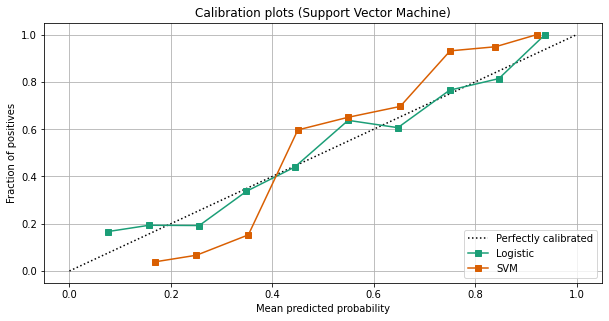

In [ ]:
fig = plt.figure(figsize=(10, 10))
gs = GridSpec(4, 2)
colors = plt.cm.get_cmap("Dark2")

ax_calibration_curve = fig.add_subplot(gs[:2, :2])
calibration_displays = {}
for i, (clf, name) in enumerate(clf_list):
    clf.fit(X, y)
    display = CalibrationDisplay.from_estimator(
        clf,
        X,
        y,
        n_bins=10,
        name=name,
        ax=ax_calibration_curve,
        color=colors(i),
    )
    calibration_displays[name] = display

ax_calibration_curve.grid()
ax_calibration_curve.set_title("Calibration plots (Support Vector Machine)")